In [1]:
import pandas as pd
import numpy as np

In [7]:
data_path = "../data/"
ratings_df = pd.read_csv(data_path + "jester_ratings.csv")
jokes_df = pd.read_csv(data_path + "jester_items.csv")
display(ratings_df.head(3))

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281


In [9]:
display(jokes_df.head(3))

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \r\n\...


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# 1. Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(jokes_df['jokeText'])
tfidf_matrix.shape

(150, 2009)

In [43]:
# LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda_topics = lda.fit_transform(tfidf_matrix)
lda_topics.shape

(150, 2)

In [45]:
# Combine TF-IDF and LDA topics into a single feature set
features = np.hstack([tfidf_matrix.toarray(), lda_topics])
features.shape 

(150, 2011)

In [46]:
# Normalize features for cosine similarity calculation
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
features_normalized.shape 

(150, 2011)

In [47]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [48]:
# Create a mapping from jokeId to index in the TF-IDF matrix
joke_id_to_index = {joke_id: index for index, joke_id in enumerate(jokes_df['jokeId'])}

In [49]:
# 2. Weighted Profile Building
def build_user_profile(user_id):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Weight TF-IDF vectors by ratings
    weighted_tfidf_vectors = []
    for _, row in user_ratings.iterrows():
        joke_idx = joke_id_to_index[row['jokeId']]
        weighted_tfidf_vectors.append(features_normalized[joke_idx] * row['rating'])
    
    # Create user profile by averaging weighted TF-IDF vectors
    user_profile = np.mean(weighted_tfidf_vectors, axis=0)
    
    return user_profile

In [51]:
build_user_profile(user_id).shape , tfidf_matrix.shape 

((2011,), (150, 2009))

In [50]:
# 3. Similarity Calculation and Recommendations
def recommend_jokes(user_id, top_n=5):
    user_profile = build_user_profile(user_id)
    
    # Calculate cosine similarity between the user profile and all jokes
    similarities = cosine_similarity([user_profile], features_normalized)
    
    # Get the indices of the top_n most similar jokes
    similar_jokes_indices = similarities.flatten().argsort()[-top_n:]
    
    # Map indices back to jokeIds
    similar_jokes = jokes_df.iloc[similar_jokes_indices][['jokeId', 'jokeText']]
    similar_jokes['similarity'] = similarities.flatten()[similar_jokes_indices]
    
    return similar_jokes

In [37]:
# cosine_similarity(build_user_profile(user_id),np.asarray(tfidf_matrix))
type(build_user_profile(user_id)), type((tfidf_matrix.toarray()))

(numpy.ndarray, numpy.ndarray)

In [52]:
def evaluate_and_visualize(user_id):
    recommended_jokes = recommend_jokes(user_id, top_n=3)
    print(f"Recommended Jokes for User {user_id}")
    print(recommended_jokes)

    # Visualize topic distribution
    topic_distribution = lda.components_
    sns.heatmap(topic_distribution, annot=True, cmap="YlGnBu", xticklabels=tfidf.get_feature_names_out(), yticklabels=[f'Topic {i+1}' for i in range(lda.n_components)])
    plt.title("LDA Topic Distribution")
    plt.show()

    # Visualize similarity scores
    plt.figure(figsize=(8, 6))
    sns.barplot(x='jokeId', y='similarity', data=recommended_jokes)
    plt.title(f"Similarity Scores for Recommended Jokes (User {user_id})")
    plt.xlabel("Joke ID")
    plt.ylabel("Similarity Score")
    plt.show()

Recommended Jokes for User 1
     jokeId                                           jokeText  similarity
49       50  A guy goes into confession and says to the pri...    0.298110
75       76  There once was a man and a woman that both  go...    0.311477
126     127  A little boy goes to his dad and asks, "What i...    0.328973


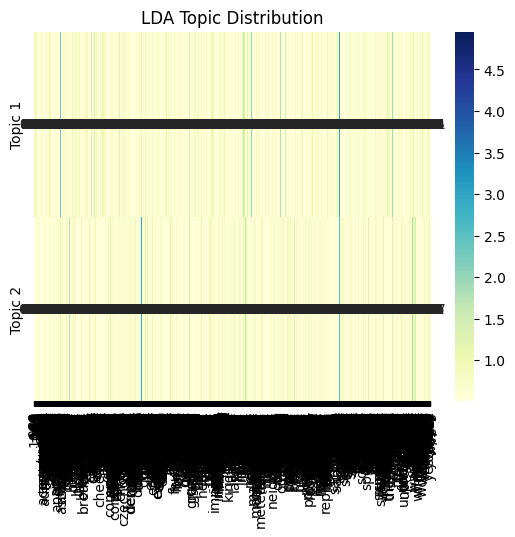

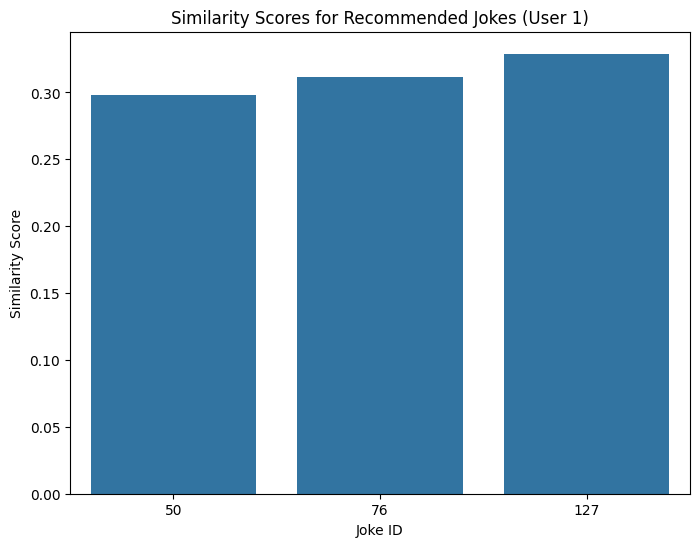

In [53]:
# 5. Run the evaluation and visualization for a specific user
user_id = 1
evaluate_and_visualize(user_id)

Recommended Jokes for User 1
     jokeId                                           jokeText  similarity
49       50  A guy goes into confession and says to the pri...    0.298110
75       76  There once was a man and a woman that both  go...    0.311477
126     127  A little boy goes to his dad and asks, "What i...    0.328973


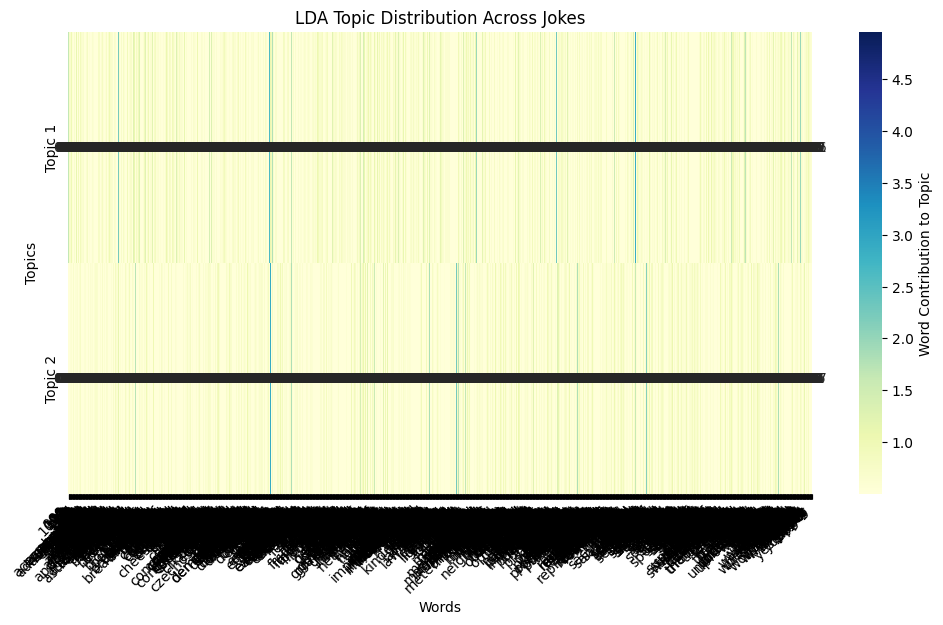

C:\Users\OMEN\AppData\Local\Temp\ipykernel_22976\2855143269.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jokeId', y='similarity', data=recommended_jokes, palette="viridis")


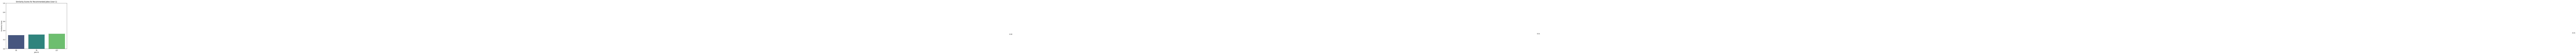

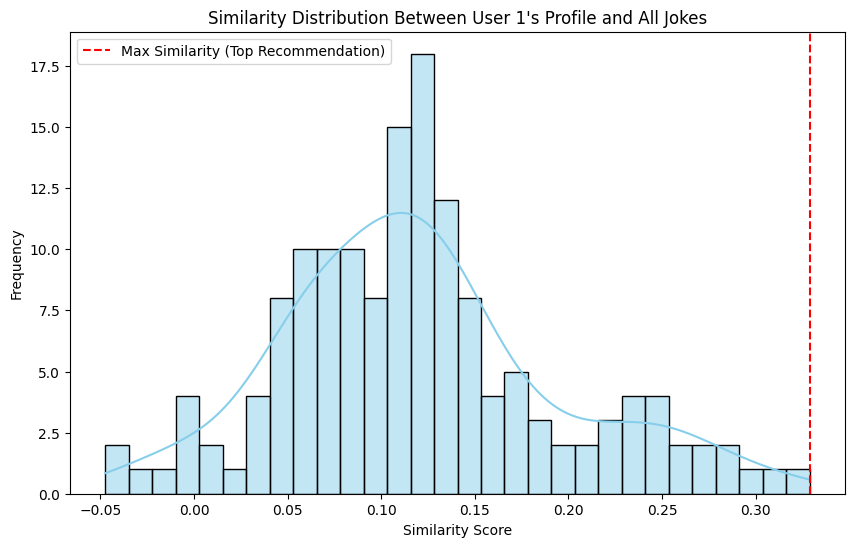

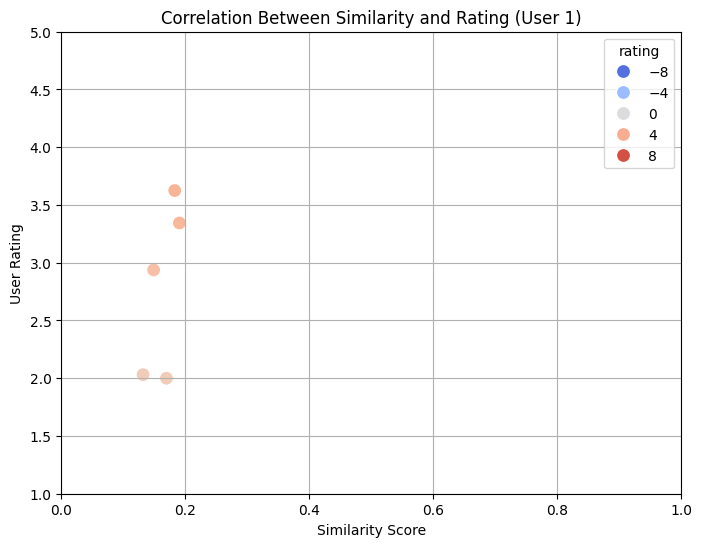

In [54]:
# 4. Metrics and Visualizations
def evaluate_and_visualize(user_id):
    recommended_jokes = recommend_jokes(user_id, top_n=3)
    print(f"Recommended Jokes for User {user_id}")
    print(recommended_jokes)

    # 1. Visualize topic distribution
    plt.figure(figsize=(12, 6))
    topic_distribution = lda.components_
    sns.heatmap(topic_distribution, annot=True, cmap="YlGnBu", 
                xticklabels=tfidf.get_feature_names_out(), 
                yticklabels=[f'Topic {i+1}' for i in range(lda.n_components)],
                cbar_kws={'label': 'Word Contribution to Topic'})
    plt.title("LDA Topic Distribution Across Jokes")
    plt.xlabel("Words")
    plt.ylabel("Topics")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # 2. Visualize similarity scores
    plt.figure(figsize=(8, 6))
    sns.barplot(x='jokeId', y='similarity', data=recommended_jokes, palette="viridis")
    for index, row in recommended_jokes.iterrows():
        plt.text(row.name, row.similarity + 0.01, f'{row.similarity:.2f}', color='black', ha="center")
    plt.title(f"Similarity Scores for Recommended Jokes (User {user_id})")
    plt.xlabel("Joke ID")
    plt.ylabel("Similarity Score")
    plt.ylim(0, 1)
    plt.show()

    # 3. Similarity distribution for user profile vs. all jokes
    user_profile = build_user_profile(user_id)
    similarities = cosine_similarity([user_profile], features_normalized).flatten()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=30, kde=True, color='skyblue')
    plt.axvline(x=similarities.max(), color='red', linestyle='--', label='Max Similarity (Top Recommendation)')
    plt.title(f"Similarity Distribution Between User {user_id}'s Profile and All Jokes")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 4. Rating vs. Similarity scatter plot
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    joke_indices = [joke_id_to_index[joke_id] for joke_id in user_ratings['jokeId']]
    joke_similarities = similarities[joke_indices]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=joke_similarities, y=user_ratings['rating'], hue=user_ratings['rating'], palette="coolwarm", s=100)
    plt.title(f"Correlation Between Similarity and Rating (User {user_id})")
    plt.xlabel("Similarity Score")
    plt.ylabel("User Rating")
    plt.ylim(1, 5)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.show()

# 5. Run the evaluation and visualization for a specific user
user_id = 1
evaluate_and_visualize(user_id)


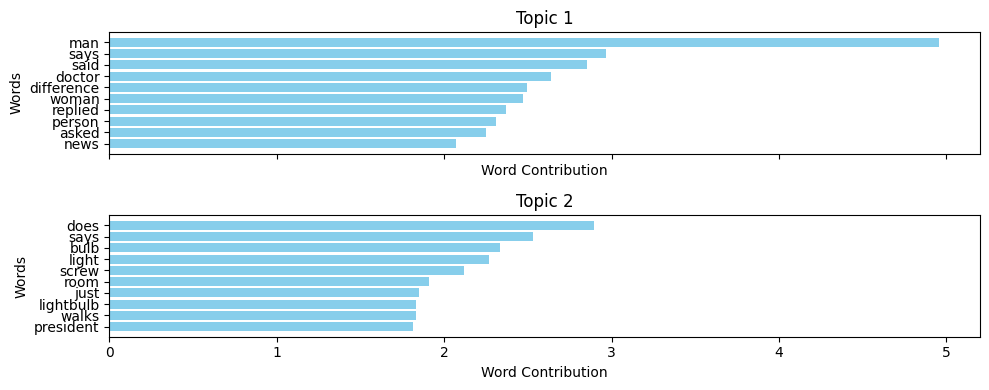

In [55]:
def plot_topic_word_contributions(lda_model, feature_names, top_n=10):
    num_topics = lda_model.n_components
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, 2*num_topics), sharex=True)
    
    for i, ax in enumerate(axes):
        # Get the top words and their contributions for this topic
        topic_word_contributions = lda_model.components_[i]
        top_word_indices = topic_word_contributions.argsort()[-top_n:][::-1]
        top_word_contributions = topic_word_contributions[top_word_indices]
        top_words = [feature_names[idx] for idx in top_word_indices]
        
        # Plot the contributions as a horizontal bar chart
        ax.barh(top_words, top_word_contributions, color='skyblue')
        ax.set_title(f'Topic {i + 1}')
        ax.set_xlabel('Word Contribution')
        ax.set_ylabel('Words')
        ax.invert_yaxis()  # To have the highest contribution word on top

    plt.tight_layout()
    plt.show()

# Call the function to plot the top word contributions for each topic
plot_topic_word_contributions(lda, tfidf.get_feature_names_out(), top_n=10)

In [38]:
def recommend_jokes(user_id, top_n=5):
    user_profile = build_user_profile(user_id)
    
    # Calculate cosine similarity between the user profile and all jokes
    similarities = cosine_similarity(user_profile, tfidf_matrix.toarray())
    
    # Get the indices of the top_n most similar jokes
    similar_jokes_indices = similarities.argsort().flatten()[-top_n:]
    
    # Map indices back to jokeIds
    similar_jokes = jokes_df.iloc[similar_jokes_indices][['jokeId', 'jokeText']]
    
    return similar_jokes

In [39]:
user_id = 1  # Specify the user ID for which to recommend jokes
recommended_jokes = recommend_jokes(user_id, top_n=3)

In [40]:
print("Recommended Jokes for User", user_id)
print(recommended_jokes)

Recommended Jokes for User 1
     jokeId                                           jokeText
86       87  A man, recently completing a routine physical ...
126     127  A little boy goes to his dad and asks, "What i...
75       76  There once was a man and a woman that both  go...
